In [8]:
import os
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
import tensorflow as tf

In [16]:
def unet_32to128(input_shape=(32, 32, 3), n_classes=3, final_activation='sigmoid', dropout_rate=0.05):
    inputs = Input(shape=input_shape, name='img')

    # Encoder
    c1 = Conv2D(16, (3,3), padding='same')(inputs)
    c1 = BatchNormalization()(c1); c1 = Activation('relu')(c1)
    c1 = Conv2D(16, (3,3), padding='same')(c1)
    c1 = BatchNormalization()(c1); c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2,2))(c1); p1 = Dropout(dropout_rate)(p1)   # 32 -> 16

    c2 = Conv2D(32, (3,3), padding='same')(p1)
    c2 = BatchNormalization()(c2); c2 = Activation('relu')(c2)
    c2 = Conv2D(32, (3,3), padding='same')(c2)
    c2 = BatchNormalization()(c2); c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2,2))(c2); p2 = Dropout(dropout_rate)(p2)   # 16 -> 8

    c3 = Conv2D(64, (3,3), padding='same')(p2)
    c3 = BatchNormalization()(c3); c3 = Activation('relu')(c3)
    c3 = Conv2D(64, (3,3), padding='same')(c3)
    c3 = BatchNormalization()(c3); c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2,2))(c3); p3 = Dropout(dropout_rate)(p3)   # 8 -> 4

    # Bottleneck (4x4)
    c4 = Conv2D(256, (3,3), padding='same')(p3)
    c4 = BatchNormalization()(c4); c4 = Activation('relu')(c4)
    c4 = Conv2D(256, (3,3), padding='same')(c4)
    c4 = BatchNormalization()(c4); c4 = Activation('relu')(c4)

    # Decoder (back to 64x64)
    u5 = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(c4)  # 4 -> 8
    u5 = concatenate([u5, c3]); u5 = Dropout(dropout_rate)(u5)
    u5 = Conv2D(128, (3,3), padding='same')(u5)
    u5 = BatchNormalization()(u5); u5 = Activation('relu')(u5)
    u5 = Conv2D(128, (3,3), padding='same')(u5)
    u5 = BatchNormalization()(u5); u5 = Activation('relu')(u5)

    u6 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(u5)    # 8 -> 16
    u6 = concatenate([u6, c2]); u6 = Dropout(dropout_rate)(u6)
    u6 = Conv2D(64, (3,3), padding='same')(u6)
    u6 = BatchNormalization()(u6); u6 = Activation('relu')(u6)
    u6 = Conv2D(64, (3,3), padding='same')(u6)
    u6 = BatchNormalization()(u6); u6 = Activation('relu')(u6)

    u7 = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(u6)    # 16 -> 32
    u7 = concatenate([u7, c1]); u7 = Dropout(dropout_rate)(u7)
    u7 = Conv2D(32, (3,3), padding='same')(u7)
    u7 = BatchNormalization()(u7); u7 = Activation('relu')(u7)
    u7 = Conv2D(32, (3,3), padding='same')(u7)
    u7 = BatchNormalization()(u7); u7 = Activation('relu')(u7)

    u8 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u7)    # 32 -> 64
    u8 = Dropout(dropout_rate)(u8)
    u8 = Conv2D(16, (3,3), padding='same')(u8)
    u8 = BatchNormalization()(u8); u8 = Activation('relu')(u8)
    u8 = Conv2D(16, (3,3), padding='same')(u8)
    u8 = BatchNormalization()(u8); u8 = Activation('relu')(u8)

    # Extra upsample to reach 128x128 (no skip)
    u9 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u8)   # 64 -> 128
    u9 = Dropout(dropout_rate)(u9)
    u9 = Conv2D(16, (3,3), padding='same')(u9)
    u9 = BatchNormalization()(u9); u9 = Activation('relu')(u9)

    outputs = Conv2D(n_classes, (1,1), activation=final_activation, name='mask')(u9)
    
    return Model(inputs=inputs, outputs=outputs, name='UNet_32to128')

In [17]:
model = unet_32to128(input_shape=(32,32,3), n_classes=3, final_activation='sigmoid')

print('Input shape:', model.input_shape)   
print('Output shape:', model.output_shape)

model.compile(optimizer=Adam(1e-4), loss='mae' )

Input shape: (None, 32, 32, 3)
Output shape: (None, 128, 128, 3)


In [19]:
import os 
import cv2 as cv
import numpy as np

imgs = os.listdir('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/')


def datagen(batch_size):
    
    while True:
        x_batch = []
        y_batch = []
        
        for _ in range(batch_size):
            indx = np.random.randint(0, len(imgs))
            
            bgr = cv.imread('/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/' + imgs[indx])
            bgr = cv.resize(bgr, (128, 128))
            rgb = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)

            # blur = cv.blur(rgb, (4, 4))

            x = cv.resize(rgb, (32, 32))
            x = x / 255.0
            y = rgb / 255.0

            x_batch.append(x)
            y_batch.append(y)
        
        x_batch = np.array(x_batch).reshape(batch_size, 32, 32, 3)
        y_batch = np.array(y_batch).reshape(batch_size, 128, 128, 3)
        
        yield x_batch, y_batch

In [21]:
batch_size = 32

batch_size = 32
num_images = len(imgs)
steps_per_epoch = num_images // batch_size 


results = model.fit(datagen(batch_size=batch_size), steps_per_epoch=steps_per_epoch , epochs=5, verbose=1)

Epoch 1/5
6331/6331 [==============================] - 1328s 210ms/step - loss: 0.0350
Epoch 2/5
6331/6331 [==============================] - 1119s 177ms/step - loss: 0.0345
Epoch 3/5
6331/6331 [==============================] - 924s 146ms/step - loss: 0.0340
Epoch 4/5
6331/6331 [==============================] - 899s 142ms/step - loss: 0.0336
Epoch 5/5
6331/6331 [==============================] - 937s 148ms/step - loss: 0.0333


Epoch 1/3
6331/6331 [==============================] - ETA: 0s - loss: 0.0327

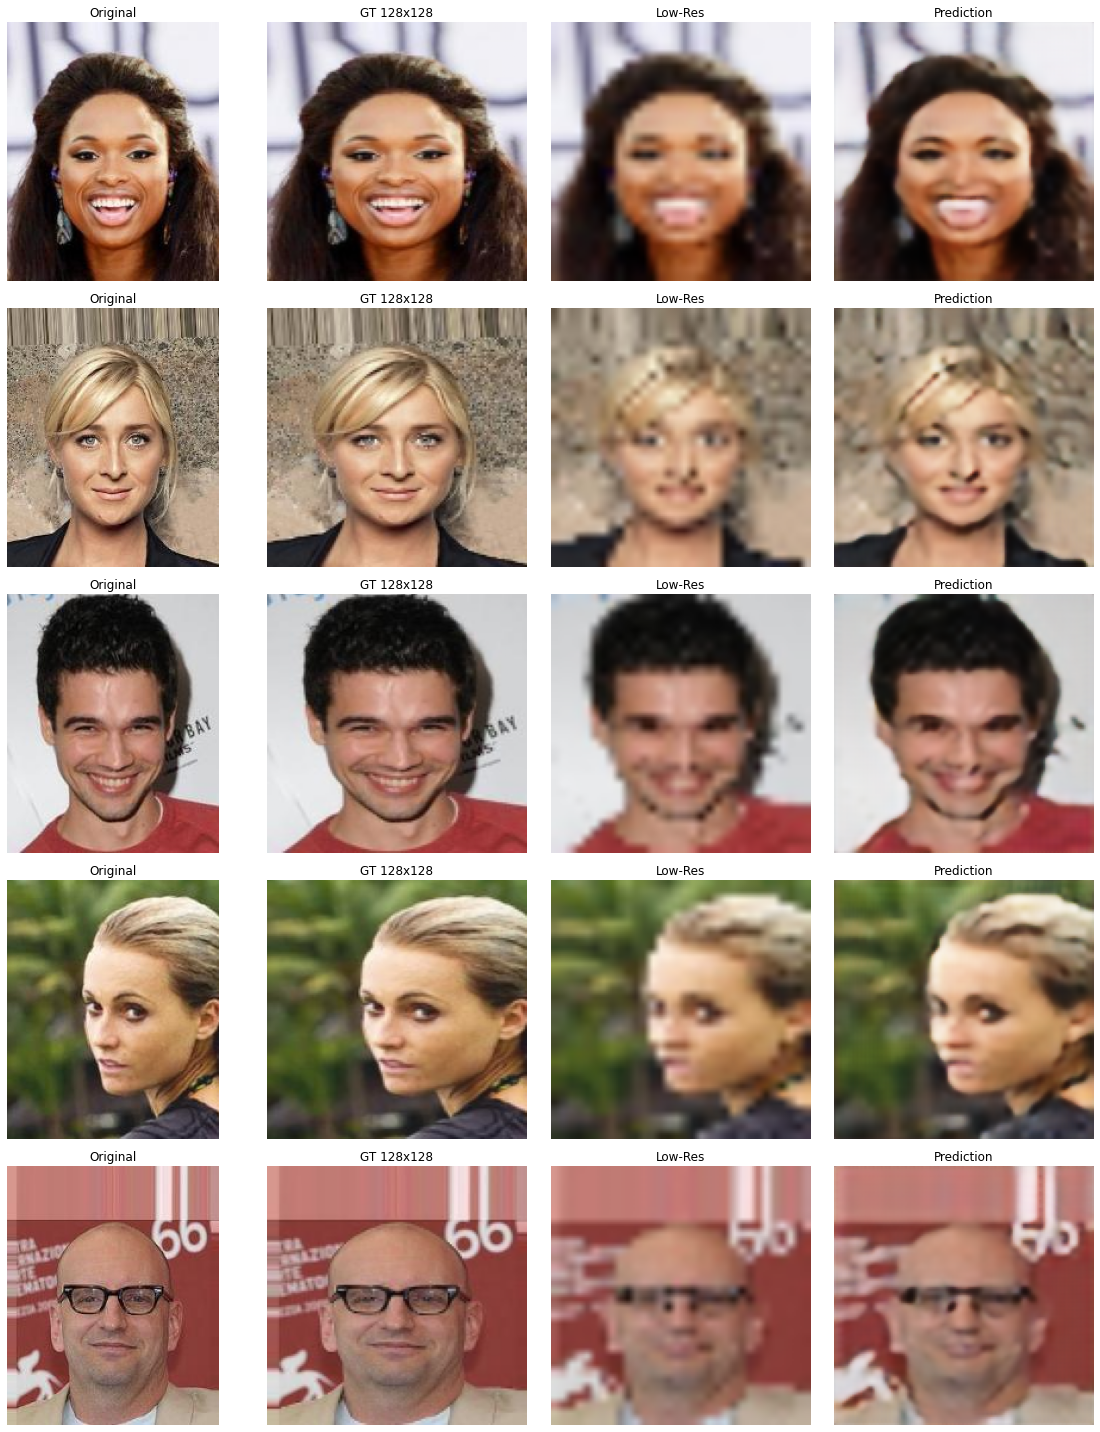

6331/6331 [==============================] - 920s 145ms/step - loss: 0.0327
Epoch 2/3
6331/6331 [==============================] - ETA: 0s - loss: 0.0325

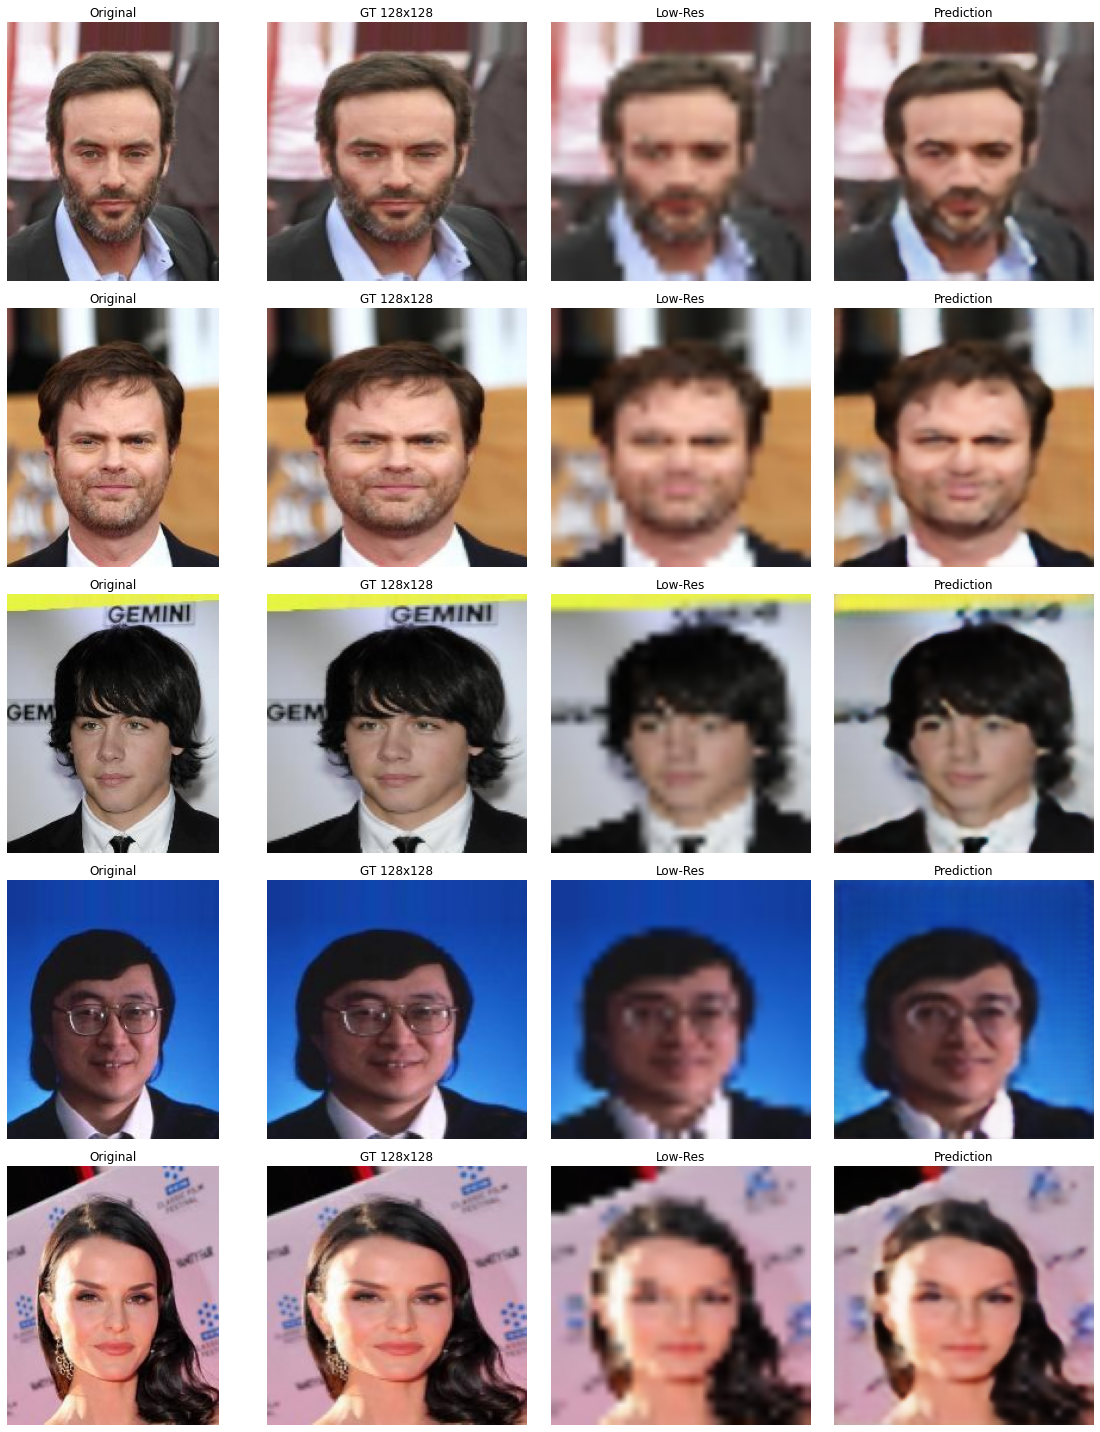

6331/6331 [==============================] - 947s 150ms/step - loss: 0.0325
Epoch 3/3
6331/6331 [==============================] - ETA: 0s - loss: 0.0322

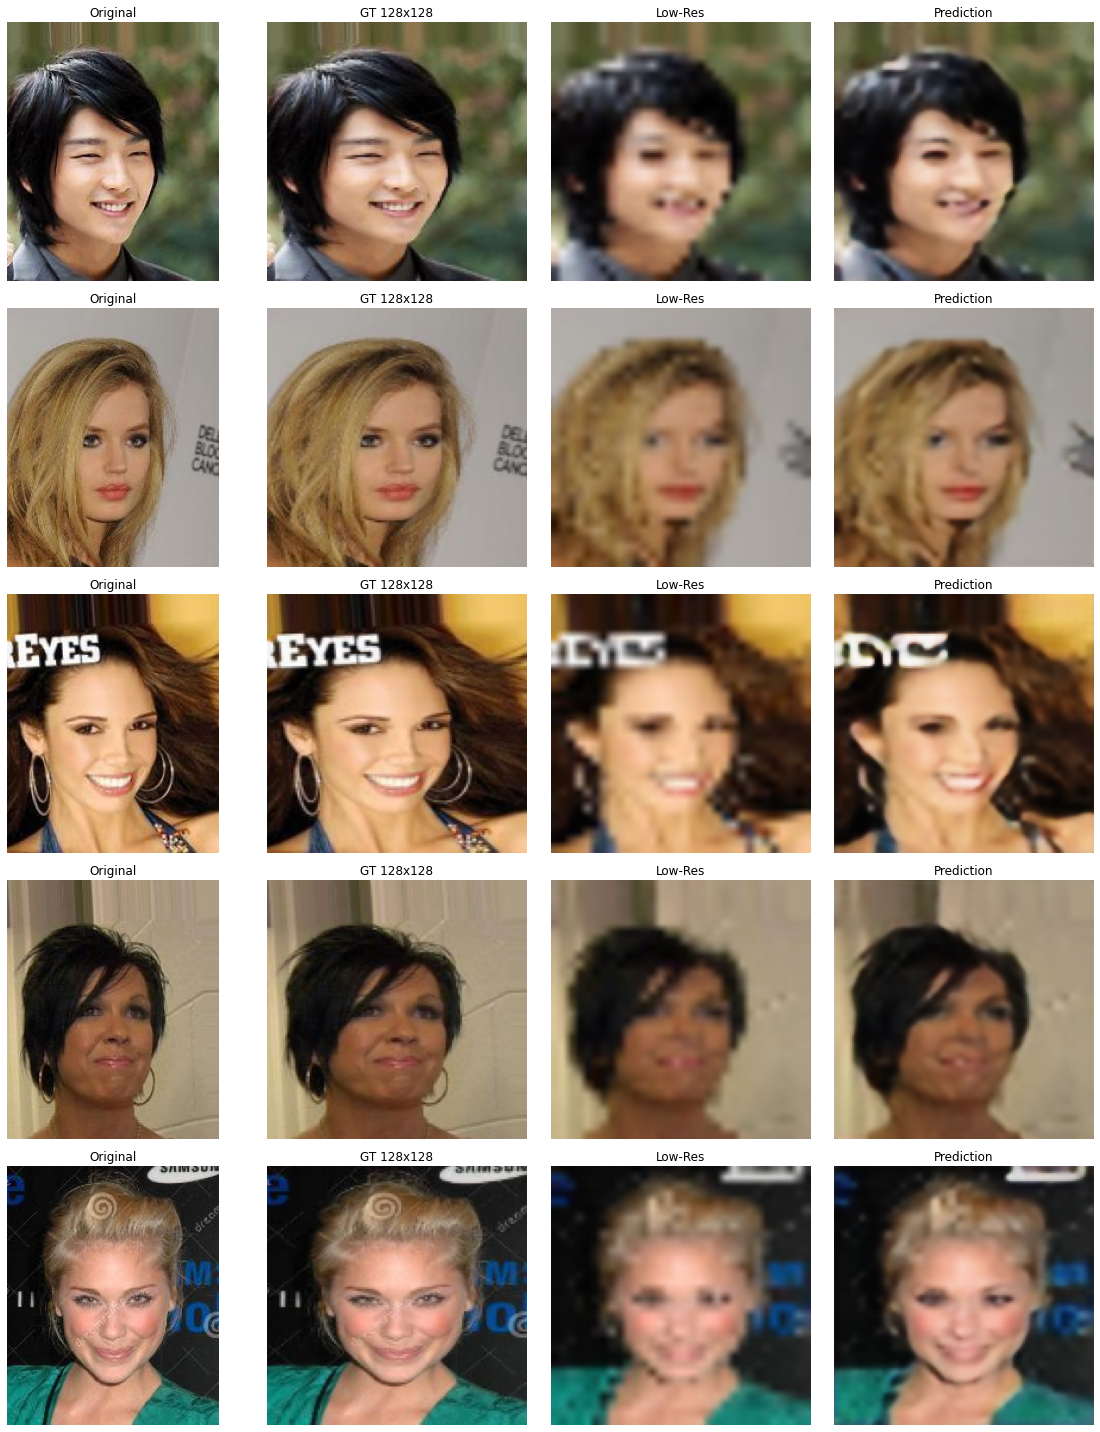

6331/6331 [==============================] - 1019s 161ms/step - loss: 0.0322


In [25]:
import os, cv2 as cv, numpy as np, matplotlib.pyplot as plt, tensorflow as tf

def show_and_save_samples(model, imgs, base_dir, epoch, n=5, save_dir='./epoch_samples'):
    os.makedirs(save_dir, exist_ok=True)
    chosen = np.random.choice(imgs, n, replace=False)
    fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))
    if n == 1: axes = np.expand_dims(axes, 0)

    for i, fname in enumerate(chosen):
        path = os.path.join(base_dir, fname)
        rgb = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)
        gt128 = cv.resize(rgb, (128,128)).astype('float32')/255
        img32 = cv.resize(rgb, (32,32)).astype('float32')/255
        pred  = model.predict(np.expand_dims(img32,0), verbose=0)[0]
        lowup = cv.resize((img32*255).astype(np.uint8),(128,128))

        for ax, im, title in zip(axes[i],[rgb,gt128,lowup,pred],
                                 ['Original','GT 128x128','Low-Res','Prediction']):
            ax.imshow(im); ax.set_title(title); ax.axis('off')

    plt.tight_layout(); plt.savefig(f"{save_dir}/epoch_{epoch+1:02d}.png"); plt.show()

# --- Simple Callbacks ---
def on_epoch_end(epoch, logs):
    show_and_save_samples(model, imgs, base_dir, epoch, n=5)
    model.save(f'./checkpoints/model_epoch_{epoch+1:02d}.keras')

show_cb = tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)


batch_size = 32
steps_per_epoch = len(imgs)//batch_size
base_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'
os.makedirs('./checkpoints', exist_ok=True)

results = model.fit(
    datagen(batch_size=batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    callbacks=[show_cb],
    verbose=1)